In [1]:
from astropy.timeseries import LombScargle
import george
from george import kernels

np.random.seed(42)

In [2]:
path = '/Users/mbedell/python/thethethe/cadence/'
t_zenith = np.genfromtxt(path+'t_zeniths.txt', skip_header=1)
t_randomized = np.genfromtxt(path+'t_randomized.txt', skip_header=1)
t_super_random = np.genfromtxt(path+'t_super_random.txt', skip_header=1)
t_zenith_strict = np.genfromtxt(path+'t_zeniths_strict.txt', skip_header=1)

In [3]:
assert len(t_zenith) == len(t_randomized)
assert len(t_super_random) == len(t_randomized)

In [4]:
len(t_zenith)

2556

In [5]:
# introduce a little noise to help decorrelate these two:
t_zenith += np.random.normal(0., 10./60./24., len(t_zenith)) # 10-minute perturbation
t_zenith_strict += np.random.normal(0., 10./60./24., len(t_zenith_strict)) # 10-minute perturbation

In [6]:
# patch up ends of observing seasons where randomizing failed
bad_inds = np.arange(len(t_randomized))[~np.isfinite(t_randomized)]
for i in bad_inds:
    t_randomized[i] = t_zenith[i]
print(bad_inds)

[1534 2300]


### window functions:

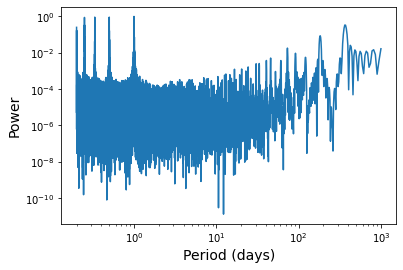

In [7]:
ys_zenith = np.ones_like(t_zenith)/len(t_zenith)
frequency, power_zenith = LombScargle(t_zenith, 
                                      ys_zenith, 
                                      fit_mean=False, 
                                      center_data=False).autopower(minimum_frequency=0.001,
                                                   maximum_frequency=5.,
                                                   samples_per_peak=5)
plt.loglog(1./frequency, power_zenith)
plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Power', fontsize=14);

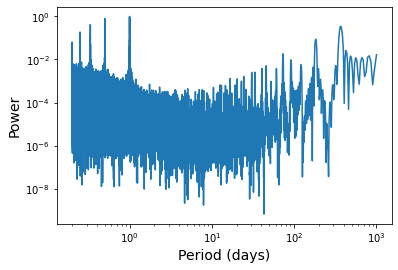

In [8]:
ys_randomized = np.ones_like(t_randomized)/len(t_randomized)
power_randomized = LombScargle(t_randomized, 
                               ys_randomized, fit_mean=False, center_data=False).power(frequency)
plt.loglog(1./frequency, power_randomized)
plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Power', fontsize=14);
#plt.axvline(0.33, color='C1', alpha=0.7, ls='--');

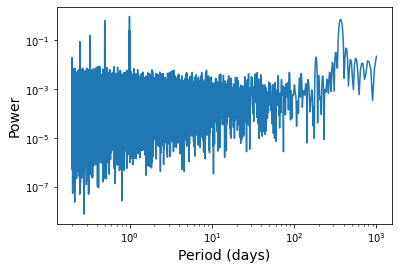

In [9]:
ys_super_random = np.ones_like(t_super_random)/len(t_super_random)
power_super_random = LombScargle(t_super_random, 
                                      ys_super_random, 
                                      fit_mean=False, 
                                      center_data=False).power(frequency)
plt.loglog(1./frequency, power_super_random)
plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Power', fontsize=14);

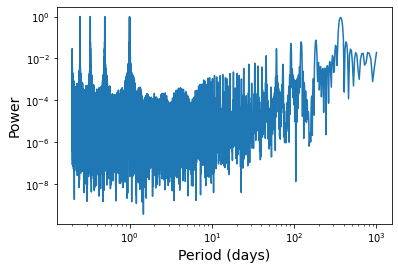

In [10]:
ys_zenith_strict = np.ones_like(t_zenith_strict)/len(t_zenith_strict)
power_zenith_strict = LombScargle(t_zenith_strict, 
                                      ys_zenith_strict, 
                                      fit_mean=False, 
                                      center_data=False).power(frequency)
plt.loglog(1./frequency, power_zenith_strict)
plt.xlabel('Period (days)', fontsize=14)
plt.ylabel('Power', fontsize=14);

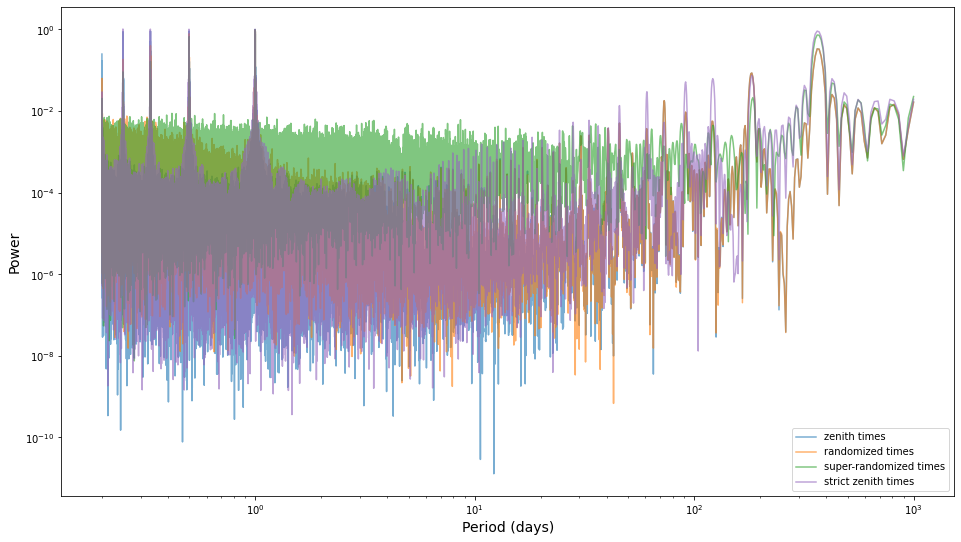

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax.plot(1./frequency, power_zenith, alpha=0.6, label='zenith times')
ax.plot(1./frequency, power_randomized, alpha=0.6, label='randomized times')
ax.plot(1./frequency, power_super_random, alpha=0.6, label='super-randomized times')
ax.plot(1./frequency, power_zenith_strict, alpha=0.6, label='strict zenith times', color='C4') #i hate red
ax.set_xlabel('Period (days)', fontsize=14)
ax.set_ylabel('Power', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();

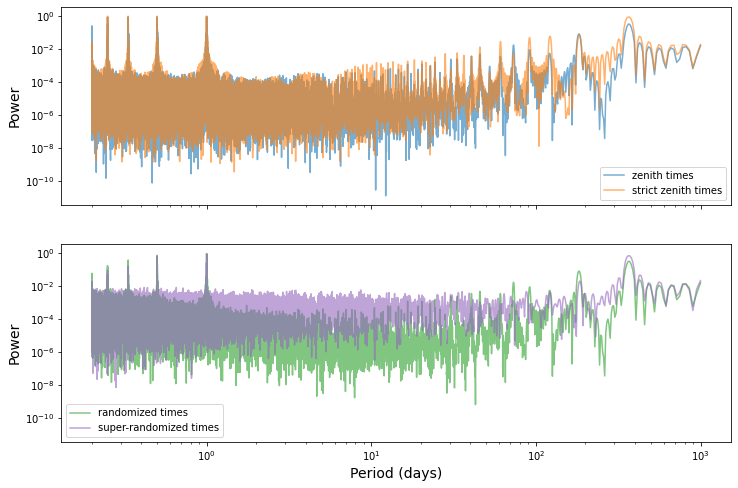

In [12]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True, sharey=True)
ax1.plot(1./frequency, power_zenith, alpha=0.6, label='zenith times')
ax1.plot(1./frequency, power_zenith_strict, alpha=0.6, label='strict zenith times')
ax2.plot(1./frequency, power_randomized, alpha=0.6, label='randomized times', color='C2')
ax2.plot(1./frequency, power_super_random, alpha=0.6, label='super-randomized times', color='C4')
ax2.set_xlabel('Period (days)', fontsize=14)
for ax in (ax1, ax2):
    ax.set_ylabel('Power', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend();

Hogg sez: there should be no difference in the window function. The reason that these strategies may be different is that under the context of red noise (incl. linear drift or seasonal offsets) that you cannot/do not model, a degeneracy builds between that noise and the sidereal period --> spurious peaks appear. GP with zero mean, low amplitude, long (months) correlation time - prediction that this will lead to false periodogram peaks in the periodic case

Aperiodic observing is better than periodic observing but only if you have noise - but that noise could be below the level of detection.

Add white noise + correlated calibration drifts that are below the level of the detectable noise:
- linear ramp
- GP w/ long correlation time
- summer shutdowns / instrument epochs

### Periodograms of noisy timeseries

In [13]:
# inject white noise
noise_amp = 0.3 # m/s
ys_zenith = np.random.normal(0., noise_amp, len(t_zenith))
yerrs_zenith = np.zeros_like(ys_zenith) + noise_amp
ys_randomized = np.random.normal(0., noise_amp, len(t_randomized))
yerrs_randomized = np.zeros_like(ys_randomized) + noise_amp
ys_zenith_strict = np.random.normal(0., noise_amp, len(t_zenith_strict))
yerrs_zenith_strict = np.zeros_like(ys_zenith_strict) + noise_amp
ys_super_random = np.random.normal(0., noise_amp, len(t_super_random))
yerrs_super_random = np.zeros_like(ys_super_random) + noise_amp

In [14]:
def plot_periodograms(ys_zenith, ys_zenith_strict, ys_randomized, ys_super_random):
    frequency, power_zenith = LombScargle(t_zenith, 
                                      ys_zenith, dy=yerrs_zenith).autopower(minimum_frequency=0.001,
                                                   maximum_frequency=5.,
                                                   samples_per_peak=7)
    power_randomized = LombScargle(t_randomized, 
                               ys_randomized, dy=yerrs_randomized).power(frequency)
    power_zenith_strict = LombScargle(t_zenith_strict, 
                               ys_zenith_strict, dy=yerrs_zenith_strict).power(frequency)
    power_super_random = LombScargle(t_super_random, 
                               ys_super_random, dy=yerrs_super_random).power(frequency)
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True, sharey=True)
    ax1.plot(1./frequency, power_zenith, alpha=0.6, label='zenith times')
    ax1.plot(1./frequency, power_zenith_strict, alpha=0.6, label='strict zenith times')
    ax2.plot(1./frequency, power_randomized, alpha=0.6, label='randomized times', color='C2')
    ax2.plot(1./frequency, power_super_random, alpha=0.6, label='super-randomized times', color='C4')
    ax2.set_xlabel('Period (days)', fontsize=14)
    for ax in (ax1, ax2):
        ax.set_ylabel('Power', fontsize=14)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend();
    
def plot_timeseries(ys_zenith, ys_zenith_strict, ys_randomized, ys_super_random):
    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True, sharey=True)
    ax1.errorbar(t_zenith, ys_zenith, yerrs_zenith, ls='', 
                fmt='o', alpha=0.7, label='zenith times')
    ax1.errorbar(t_zenith_strict, ys_zenith_strict, yerrs_zenith_strict, ls='', 
                fmt='o', alpha=0.7, label='strict zenith times')
    ax2.errorbar(t_randomized, ys_randomized, yerrs_randomized, ls='', 
                fmt='o', alpha=0.7, label='randomized times', color='C2')
    ax2.errorbar(t_super_random, ys_super_random, yerrs_super_random, ls='', 
                fmt='o', alpha=0.7, label='super-randomized times', color='C4')
    ax2.set_xlabel('Time (days)', fontsize=14)
    for ax in (ax1, ax2):
        ax.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
        ax.legend();
    return fig, (ax1,ax2)

#### white noise only:

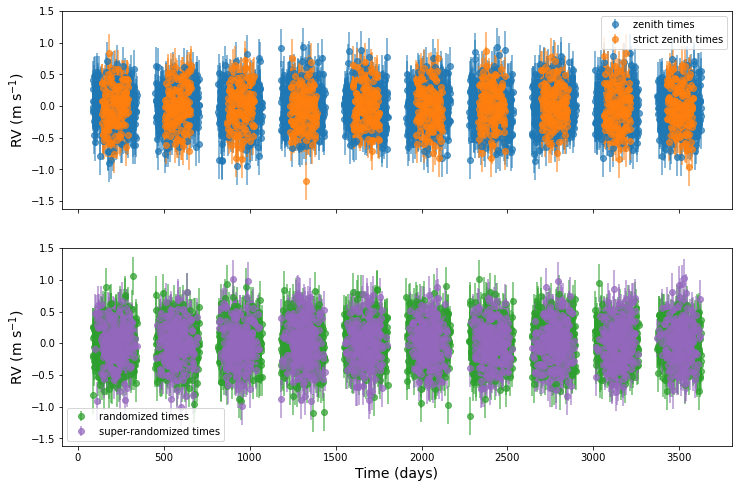

In [15]:
plot_timeseries(ys_zenith, ys_zenith_strict, ys_randomized, ys_super_random);

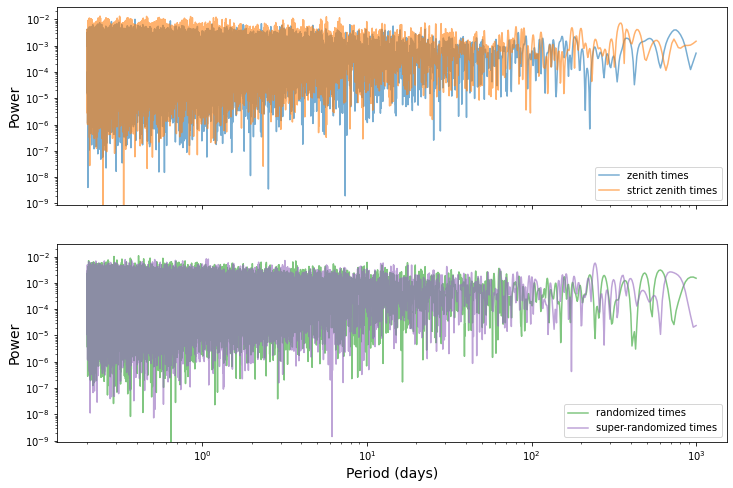

In [16]:
plot_periodograms(ys_zenith, ys_zenith_strict, ys_randomized, ys_super_random)

#### linear ramp:

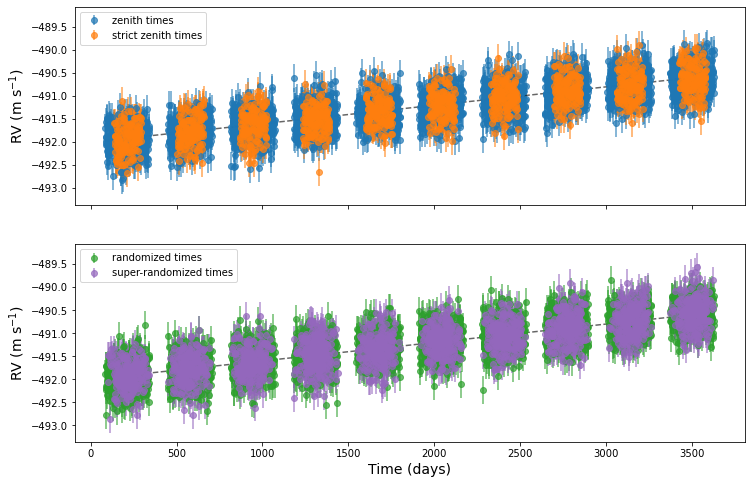

In [17]:
def linear_trend(xs, m=4.e-4, b=-246.*2):
    return m*xs + b

ys_zenith_lin = ys_zenith + linear_trend(t_zenith)
ys_randomized_lin = ys_randomized + linear_trend(t_randomized)
ys_zenith_strict_lin = ys_zenith_strict + linear_trend(t_zenith_strict)
ys_super_random_lin = ys_super_random + linear_trend(t_super_random)


fig,(ax1,ax2) = plot_timeseries(ys_zenith_lin, ys_zenith_strict_lin, 
                                ys_randomized_lin, ys_super_random_lin)
ax1.plot(t_zenith, linear_trend(t_zenith), ls='--', c='k', alpha=0.6)
ax2.plot(t_zenith, linear_trend(t_zenith), ls='--', c='k', alpha=0.6)

plt.show()

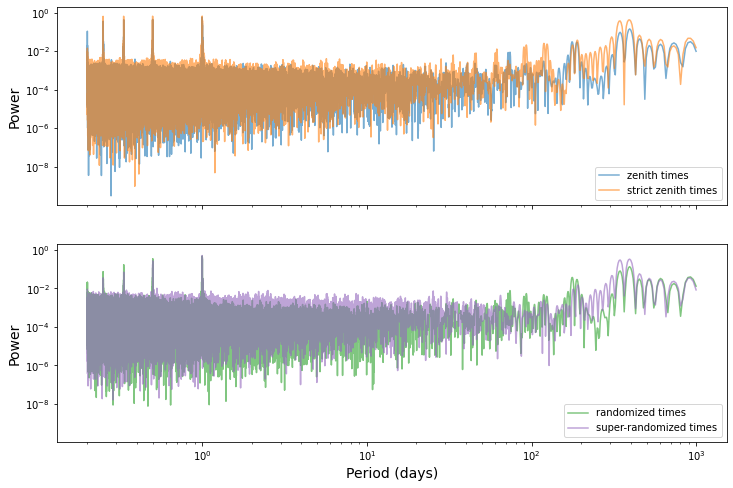

In [18]:
plot_periodograms(ys_zenith_lin, ys_zenith_strict_lin, 
                  ys_randomized_lin, ys_super_random_lin)

#### correlated noise:

In [19]:
time_lag = 5. # days
kernel = noise_amp**2 * kernels.ExpSquaredKernel(time_lag) # TODO - check on use of time_lag
gp = george.GP(kernel)
#gp.compute(t_obs_zenith) # TODO - do I need to input error bars? what does that do?
ys_zenith_gp = ys_zenith + gp.sample(t_zenith)
ys_zenith_strict_gp = ys_zenith_strict + gp.sample(t_zenith_strict)
ys_randomized_gp = ys_randomized + gp.sample(t_randomized)
ys_super_random_gp = ys_super_random + gp.sample(t_super_random)

choose a kernel that's high at delta t = 0 and decays away from there, value there is the variance (could be equivalent to the white noise)

make matrix of all time differences between observations i and j

put into every element of matrix the value of the kernel

draw one Gaussian draw with that variance tensor - that draw will be the red noise

diagonal of covariance matrix does not have zeros on the diagonal because those are the marginalized noise

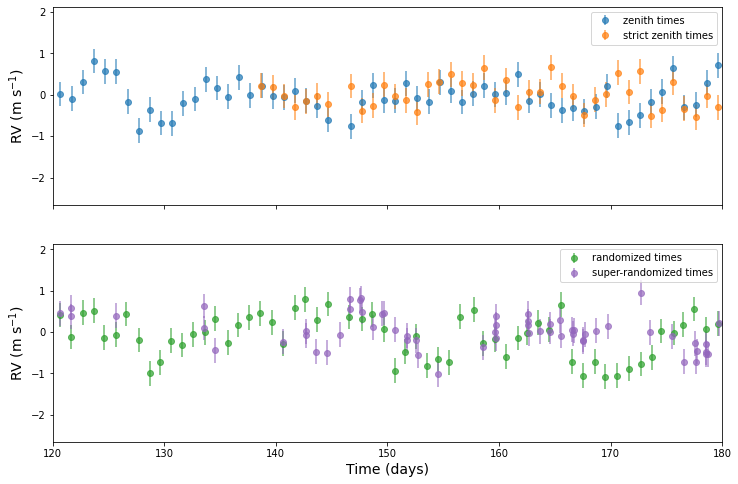

In [20]:
fig,(ax1,ax2) = plot_timeseries(ys_zenith_gp, ys_zenith_strict_gp, 
                                ys_randomized_gp, ys_super_random_gp)
ax1.set_xlim([120,180]);

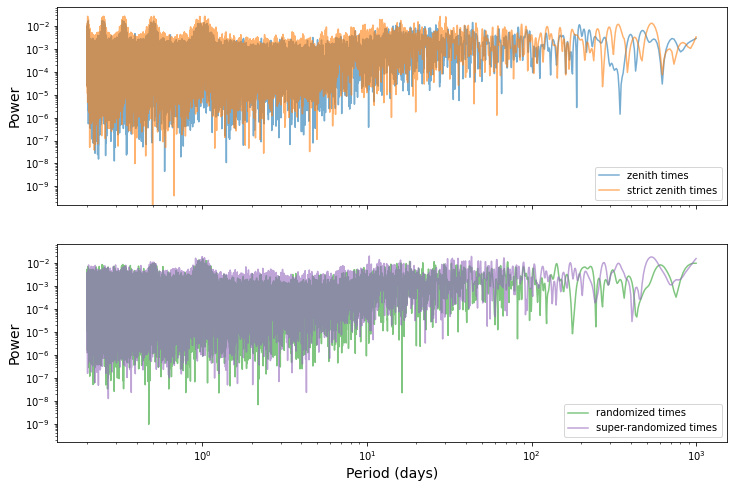

In [21]:
plot_periodograms(ys_zenith_gp, ys_zenith_strict_gp, 
                                ys_randomized_gp, ys_super_random_gp)